# Task
Predict annual water usage in Baltimore

In [21]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [22]:
# Reading in the data

df = pd.read_csv('./data/yearly-water-usage.csv', index_col=0, parse_dates=True)
df.head()

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413


In [23]:
# Viewing the shape of the data

df.shape

(79, 1)

In [24]:
# Viewing the range of dates

print(f"Time range: {df.index.min()} - {df.index.max()}")

Time range: 1885-01-01 00:00:00 - 1963-01-01 00:00:00


In [25]:
# Checking if there are any duplicate years

np.sum(df.index.value_counts() > 1)

0

In [26]:
# Checking the summary statistics

df.describe()

,Water
count,79.000000
mean,512.025316
std,75.685072
min,344.000000
25%,462.000000
50%,503.000000
75%,581.000000
max,662.000000


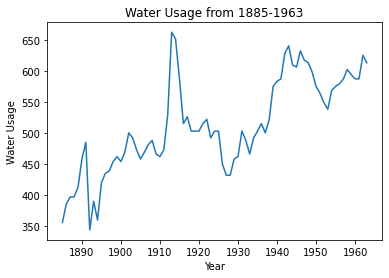

In [27]:
# Plotting the time series

plt.plot(df)
plt.title('Water Usage from 1885-1963')
plt.xlabel('Year')
plt.ylabel('Water Usage');

* there is an upward trend
* there might be some seaonality within 20 years
  * it seems like to spike up and then spike down a bit
* big spike around the year 1912-1915

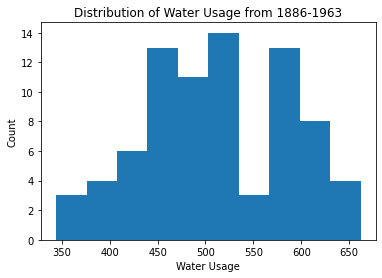

In [28]:
# Viewing the distribution

plt.hist(df['Water'])
plt.title('Distribution of Water Usage from 1886-1963')
plt.xlabel('Water Usage')
plt.ylabel('Count');

In [29]:
# Splitting the data

split_point = df.shape[0] - 10
train, test = df[:split_point], df[split_point:]
print(f'Train: {train.shape}, Test: {test.shape}')

Train: (69, 1), Test: (10, 1)


In [30]:
# Converting train into series

series = pd.Series(train['Water'])

In [31]:
# Splitting the data further into train and valid

X = series.values
X = X.astype('float32')
train_size = int(len(X)*0.5)
train, valid = X[0:train_size], X[train_size:]

In [32]:
# Walk-Forward Validation

history = [x for x in train]
predictions = []

for i in range(len(valid)):
  
  ## Predictions using Persistance Model
  yhat = history[-1]
  predictions.append(yhat)

  ## Observations
  obs = valid[i]
  history.append(obs)
  print(f'>Predicted: {yhat:.3f}, Expected: {obs:.3f}')

## Calculating RMSE for Persistance Model
rmse = np.sqrt(mean_squared_error(valid, predictions))
print(f"RMSE: {rmse:.3f}")

>Predicted: 503.000, Expected: 503.000
>Predicted: 503.000, Expected: 503.000
>Predicted: 503.000, Expected: 515.000
>Predicted: 515.000, Expected: 522.000
>Predicted: 522.000, Expected: 492.000
>Predicted: 492.000, Expected: 503.000
>Predicted: 503.000, Expected: 503.000
>Predicted: 503.000, Expected: 450.000
>Predicted: 450.000, Expected: 432.000
>Predicted: 432.000, Expected: 432.000
>Predicted: 432.000, Expected: 458.000
>Predicted: 458.000, Expected: 462.000
>Predicted: 462.000, Expected: 503.000
>Predicted: 503.000, Expected: 488.000
>Predicted: 488.000, Expected: 466.000
>Predicted: 466.000, Expected: 492.000
>Predicted: 492.000, Expected: 503.000
>Predicted: 503.000, Expected: 515.000
>Predicted: 515.000, Expected: 500.000
>Predicted: 500.000, Expected: 522.000
>Predicted: 522.000, Expected: 575.000
>Predicted: 575.000, Expected: 583.000
>Predicted: 583.000, Expected: 587.000
>Predicted: 587.000, Expected: 628.000
>Predicted: 628.000, Expected: 640.000
>Predicted: 640.000, Expe

In [53]:
# Function that implements the walk-forward method

def walk_forward(history, predictions, df_valid, model):

    for i in range(len(df_valid)):
        
        ## Use Model to predict value
        yhat = model(history)
        predictions.append(yhat)

        obs = df_valid[i]
        history.append(yhat)
        print(f'>Predicted: {yhat:.3f}, Expected: {obs:.3f}')
    
    ## Calculating RMSE for Persistance Model
    rmse = np.sqrt(mean_squared_error(df_valid, predictions))
    print(f"RMSE: {rmse:.3f}")

In [51]:
# Function that implements naive forecasting (persistance model)

def persistance_model(history):
    return history[-1]

In [52]:
# Function that implements the ARIMA model

def ARIMA_model(history, order):
    model = ARIMA(history, order)
    model_fit = model.fit()
    return model_fit.forecast()[0]

## Data Analysis

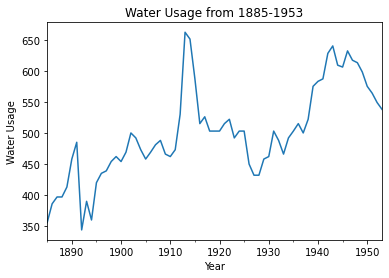

In [33]:
# Plotting a line plot

series.plot();
plt.title('Water Usage from 1885-1953')
plt.xlabel('Year')
plt.ylabel('Water Usage');

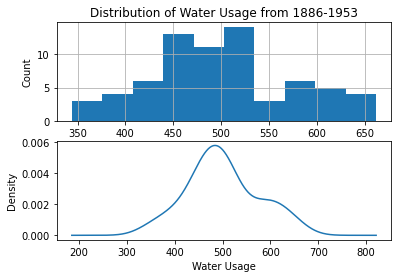

In [34]:
# Plotting density plot

plt.figure(1)

plt.subplot(2,1,1)
series.hist()
plt.title('Distribution of Water Usage from 1886-1953')
plt.ylabel('Count');

plt.subplot(2,1,2)
series.plot(kind='kde')
plt.xlabel('Water Usage')
plt.show()

<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/3h/n7g9d8x521gg4nfvf31y3_840000gn/T/ipykernel_53115/2802700883.py:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(group.values) is 10:


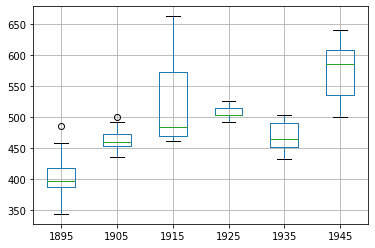

In [35]:
# Boxplots for each decade

## Grouping by decade
groups = series.groupby(pd.Grouper(freq='10Y'))
decades = pd.DataFrame()

for name, group in groups:
  if len(group.values) is 10:
    decades[name.year] = group.values
decades.boxplot()
plt.show()

* the median shows a non-linear positive trend
* the spread shows some variabiity
* there are some outliers in the first two decades
* second to last decade seems to have a lower average consumption

In [36]:
# Checking if the series is stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(X)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
  print(f'\t{key}: {value:.3f}')

ADF Statistic: -2.267302650109137
p-value: 0.1827304124561639
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


In [37]:
# Function that differences the time series

def difference(df):
  diff = []
  for i in range(1, len(df)):
    value = df[i] - df[i-1]
    diff.append(value)
  return pd.Series(diff)

In [38]:
# Differencing the data

stationary = difference(X)
stationary.index = series.index[1:]

In [39]:
# Checking if the series is stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(stationary)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
  print(f'\t{key}: {value:.3f}')

ADF Statistic: -6.126718808474715
p-value: 8.593851954694127e-08
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


the ADF statistic is smaller than the critical value at 1%
* reject the null hypothesis with a significance level of less than 1$
  * the process has no unit root
  * time series is stationary
* suggest that differencing is needed
  * at least d = 1

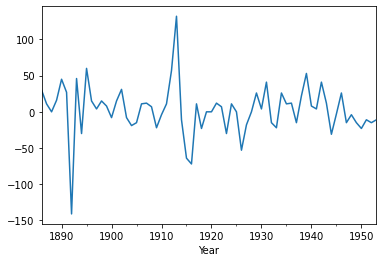

In [40]:
# Plotting the stationary series

stationary.plot()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


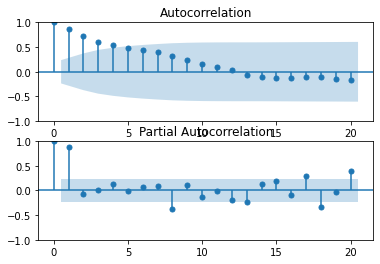

In [41]:
# Plotting ACF and PACF to determine p and q of ARIMA

import statsmodels.graphics.tsaplots as tsa

## Creating the figure
plt.figure()

## Creating the first plot
plt.subplot(2,1,1)
tsa.plot_acf(series, lags=20, ax=plt.gca())

## Creating the second plot
plt.subplot(2,1,2)
tsa.plot_pacf(series, lags=20, ax=plt.gca())
plt.show()

* the ACF shows significant lags to 4 time steps
* PACF shows significant lags to 1 time step

In [45]:
# Predicting using ARIMA

## Imports
from statsmodels.tsa.arima.model import ARIMA

## Preparing the data
X = series.values
X = X.astype('float32')

## Splitting data into train and validation set
train_size = int(len(X) * 0.50)
train, valid = X[0:train_size], X[train_size:]

## Predicting using the walk-forward method
history = [x for x in train]
predictions = []

## Looping through the number of predictions to make
for i in range(len(valid)):
  
  ### Fitting the ARIMA model
  model = ARIMA(history, order=(4,1,1))
  model_fit = model.fit()
  
  ### Predicting using the fitted ARIMA model
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)

  ### Adding the next value into history (walk-forward implementation)
  obs = valid[i]
  history.append(obs)
  print(f'>Predicted: {yhat:.3f}, Expected: {obs:.3f}')

## Calculatinf the RMSE
rmse = np.sqrt(mean_squared_error(valid, predictions))
print(f"RMSE: {rmse:.3f}")

>Predicted: 530.101, Expected: 503.000
>Predicted: 511.154, Expected: 503.000
>Predicted: 515.637, Expected: 515.000
>Predicted: 520.904, Expected: 522.000
>Predicted: 525.009, Expected: 492.000
>Predicted: 492.360, Expected: 503.000
>Predicted: 504.664, Expected: 503.000
>Predicted: 512.082, Expected: 450.000
>Predicted: 454.312, Expected: 432.000
>Predicted: 441.329, Expected: 432.000
>Predicted: 452.418, Expected: 458.000
>Predicted: 470.223, Expected: 462.000
>Predicted: 465.860, Expected: 503.000
>Predicted: 498.112, Expected: 488.000
>Predicted: 483.399, Expected: 466.000
>Predicted: 455.128, Expected: 492.000
>Predicted: 492.320, Expected: 503.000
>Predicted: 503.711, Expected: 515.000
>Predicted: 505.815, Expected: 500.000
>Predicted: 493.165, Expected: 522.000
>Predicted: 515.482, Expected: 575.000
>Predicted: 571.332, Expected: 583.000
>Predicted: 568.102, Expected: 587.000
>Predicted: 567.410, Expected: 628.000
>Predicted: 620.638, Expected: 640.000
>Predicted: 632.546, Expe

## Grid Search

In [ ]:
# # evaluate an ARIMA model for a given order (p,d,q) and return RMSE
# def evaluate_arima_model(X, arima_order): 
#   # prepare training dataset
#   X = X.astype('float32')
#   train_size = int(len(X) * 0.50)
#   train, valid = X[0:train_size], X[train_size:]
#   history = [x for x in train]
#   # make predictions
#   predictions = list()
#   for t in range(len(valid)):
#     model = ARIMA(history, order=arima_order) # model_fit = model.fit(disp=0)
#     model_fit = model.fit(trend='nc', disp=0) 
#     yhat = model_fit.forecast()[0] 
#     predictions.append(yhat) 
#     history.append(valid[t])
#   # calculate out of sample error
#   rmse = np.sqrt(mean_squared_error(valid, predictions))
#   return rmse

# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values): 
#   dataset = dataset.astype('float32')
#   best_score, best_cfg = float("inf"), None
#   for p in p_values:
#     for d in d_values:
#       for q in q_values:
#         order = (p,d,q)
#         try:
#           rmse = evaluate_arima_model(dataset, order)
#           if rmse < best_score:
#             best_score, best_cfg = rmse, order 
#           print('ARIMA%s RMSE=%.3f' % (order,rmse))
#         except:
#           continue
#   print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# # evaluate parameters
# p_values = range(0, 5)
# d_values = range(0, 3)
# q_values = range(0, 5)
# warnings.filterwarnings("ignore")
# evaluate_models(series.values, p_values, d_values, q_values)

* Running the Grid Search gives values ARIMA(2, 1, 0) as the best values

## Reviewing the Residual Errors

In [49]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, valid = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(valid)):
  model = ARIMA(history, order=(2,1,0), trend='n')
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)

  obs = valid[i]
  history.append(obs)

# report performance
rmse = np.sqrt(mean_squared_error(valid, predictions)) 
print(f'RMSE: {rmse:.3f}')

RMSE: 21.732


In [50]:
# Collecting the residuals

residuals = [valid[i]-predictions[i] for i in range(len(valid))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

               0
count  35.000000
mean    1.081458
std    22.022201
min   -52.104849
25%   -16.209637
50%    -0.454858
75%    12.089062
max    51.281127


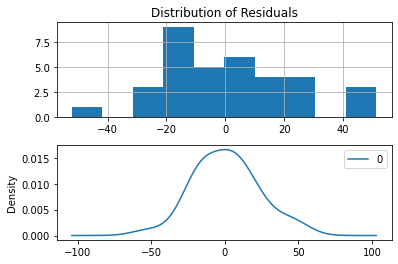

In [ ]:
# Plotting the residuals

plt.figure()
plt.subplot(2,1,1)
residuals.hist(ax=plt.gca())
plt.title("Distribution of Residuals")

plt.subplot(2,1,2)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

The mean of the residuals is 1.08 so the predictions should be corrected by that much.

In [ ]:
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, valid = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = []
bias = residuals.mean()
for i in range(len(valid)):
  # predict
  model = ARIMA(history, order=(2,1,0)) 
  model_fit = model.fit(trend='nc', disp=0) 
  yhat = bias + float(model_fit.forecast()[0]) 
  predictions.append(yhat)
  
  # observation
  obs = valid[i]
  history.append(obs)

# report performance
rmse = np.sqrt(mean_squared_error(valid, predictions)) 
print(f'RMSE: {rmse:.3f}')

RMSE: 21.706


In [ ]:
# summarize residual errors
residuals = [valid[i]-predictions[i] for i in range(len(valid))] 
residuals = pd.DataFrame(residuals)
print(residuals.describe())

                  0
count  3.500000e+01
mean   6.496391e-15
std    2.202257e+01
min   -5.318544e+01
25%   -1.728390e+01
50%   -1.541429e+00
75%    1.100347e+01
max    5.020271e+01


## Validating the Model

In [ ]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
  return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

In [ ]:
# prepare data
X = series.values
X = X.astype('float32')

# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)

# bias constant, could be calculated from in-sample mean residual bias = 1.081624
# save model
model_fit.save('model.pkl')
np.save('model_bias.npy', [bias])

In [ ]:
from statsmodels.tsa.arima_model import ARIMAResults

model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0]) 
print(f'Predicted: {yhat[0][0]:.3f}')

Predicted: 540.013


In [ ]:
# Processing the test set

y = pd.Series(test['Water'])
y = y.values.astype('float32')
y

array([568., 575., 579., 587., 602., 594., 587., 587., 625., 613.],
      dtype=float32)

In [ ]:
# Loading the model and bias

model_fit = ARIMAResults.load('model.pkl')
bias = np.load('model_bias.npy')

In [ ]:
# Making the first prediction

predictions = []
yhat = bias + float(model_fit.forecast()[0]) 
predictions.append(yhat[0])
history.append(y[0])

In [ ]:
# Rolling forecast

for i in range(1, len(y)):
  ## Predicting
  model = ARIMA(history, order=(2,1,0))
  model_fit = model.fit(trend='nc', disp=0)
  yhat = bias + float(model_fit.forecast()[0]) 
  predictions.append(yhat[0])
  
  ## Observation
  obs = y[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

>Predicted=571.589, Expected=575.000
>Predicted=573.289, Expected=579.000
>Predicted=579.561, Expected=587.000
>Predicted=588.063, Expected=602.000
>Predicted=603.022, Expected=594.000
>Predicted=593.178, Expected=587.000
>Predicted=588.558, Expected=587.000
>Predicted=588.797, Expected=625.000
>Predicted=627.941, Expected=613.000


In [ ]:
# Calculating the RMSE

rmse = np.sqrt(mean_squared_error(y, predictions))
print(f'RMSE: {rmse:.3f}')

RMSE: 16.532


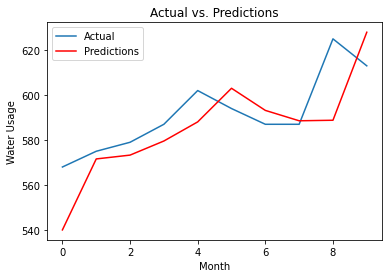

In [ ]:
# Plotting predictions and actual

plt.plot(y, label='Actual')
plt.plot(predictions, color='red', label='Predictions')
plt.title('Actual vs. Predictions')
plt.xlabel('Month')
plt.ylabel('Water Usage')
plt.legend()
plt.show()